In [1]:
import json
from collections import Counter

import matplotlib.pyplot as plt
import numpy as np
import tifffile
import torch
import torch.nn as nn
import torchvision.transforms.functional as TF
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import RandomHorizontalFlip, RandomVerticalFlip, Normalize, RandomCrop, Compose
from kmeans_pytorch import kmeans

In [2]:
%load_ext autoreload

In [3]:
%autoreload 2

In [4]:
import multiplex_imaging_pipeline.utils as utils
from vit_pytorch import ViT, MAE
from vit_pytorch.slide_mae import SlideMAE, SlideMAEV2
from vit_pytorch.slide_ae import SlideAE


In [5]:
metadata = json.load(open('../data/test_registration/HT397B1_v2/registered/metadata.json'))
metadata

{'downsample_scaler': 0.1,
 'phenocycler_pixels_per_micron': 1.9604911906033102,
 'order': ['HT397B1-S1H3A1U1',
  'HT397B1-S1H3A1U2',
  'HT397B1-S1H3A1U12',
  'HT397B1-S1H3A1U21',
  'HT397B1-S1H3A1U22',
  'HT397B1-S1H3A1U31'],
 'data_type': ['visium', 'codex', 'codex', 'visium', 'codex', 'codex'],
 'slices': ['s0', 's1', 's2', 's3', 's4', 's5']}

In [6]:
fps = sorted(utils.listfiles('/data/estorrs/mushroom/data/test_registration/HT397B1_v2/registered',
                     regex='ome.tiff$'))
fps

['/data/estorrs/mushroom/data/test_registration/HT397B1_v2/registered/s1.ome.tiff',
 '/data/estorrs/mushroom/data/test_registration/HT397B1_v2/registered/s2.ome.tiff',
 '/data/estorrs/mushroom/data/test_registration/HT397B1_v2/registered/s4.ome.tiff',
 '/data/estorrs/mushroom/data/test_registration/HT397B1_v2/registered/s5.ome.tiff']

In [7]:
pool = []
for fp in fps:
    channels = utils.get_ome_tiff_channels(fp)
    channels = [utils.R_CHANNEL_MAPPING.get(c, c) for c in channels]
    pool += channels
Counter(pool).most_common()

/data/estorrs/miniconda3/envs/mushroom/lib/python3.10/site-packages/ome_types/_convenience.py:106: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, validate=validate)


[('Bap1', 4),
 ('CD31', 4),
 ('CD45', 4),
 ('CD68', 4),
 ('CD8', 4),
 ('CK19', 4),
 ('COX6c', 4),
 ('DAPI', 4),
 ('ER', 4),
 ('FOXP3', 4),
 ('GATA3', 4),
 ('GLUT1', 4),
 ('HLA-DR', 4),
 ('Her2', 4),
 ('CK14', 4),
 ('Ki67', 4),
 ('MGP', 4),
 ('PLAT/tPA', 4),
 ('PR', 4),
 ('Pan-Cytokeratin', 4),
 ('Podoplanin', 4),
 ('SMA', 4),
 ('Vimentin', 4),
 ('cKit', 4),
 ('CD20', 2),
 ('CD3e', 2),
 ('CD11b', 1),
 ('E-cadherin', 1)]

In [8]:
channels = sorted([c for c, count in Counter(pool).items() if count==len(fps)])
channels

['Bap1',
 'CD31',
 'CD45',
 'CD68',
 'CD8',
 'CK14',
 'CK19',
 'COX6c',
 'DAPI',
 'ER',
 'FOXP3',
 'GATA3',
 'GLUT1',
 'HLA-DR',
 'Her2',
 'Ki67',
 'MGP',
 'PLAT/tPA',
 'PR',
 'Pan-Cytokeratin',
 'Podoplanin',
 'SMA',
 'Vimentin',
 'cKit']

In [9]:
channels = [ # only working channels
    'Bap1',
    'CD31',
    'CD45',
#     'CD68',
    'CD8',
    'CK14',
    'CK19',
    'COX6c',
    'DAPI',
    'ER',
    'FOXP3',
    'GATA3',
    'GLUT1',
    'HLA-DR',
    'Her2',
    'Ki67',
    'MGP',
    'PLAT/tPA',
    'PR',
    'Pan-Cytokeratin',
    'Podoplanin',
    'SMA',
    'Vimentin',
    'cKit'
]

In [10]:
scale = .1
slide_to_img = {}
for fp in fps:
    sample = fp.split('/')[-1].replace('.ome.tiff', '')
    cs, img = utils.extract_ome_tiff(fp, as_dict=False)
    img = torch.tensor(img)
    thumbnail = TF.resize(img, (int(scale * img.shape[-2]), int(scale * img.shape[-1])))
    thumbnail = thumbnail.to(torch.float32)
    
    cs = [utils.R_CHANNEL_MAPPING[c] for c in cs]
    idxs = [cs.index(c) for c in channels]
    thumbnail = thumbnail[idxs]
    
    slide_to_img[sample] = thumbnail

In [11]:
thumbnail = next(iter(slide_to_img.values()))

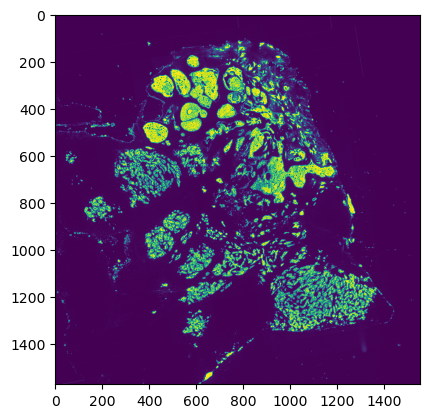

In [12]:
plt.imshow(thumbnail[channels.index('Pan-Cytokeratin')])

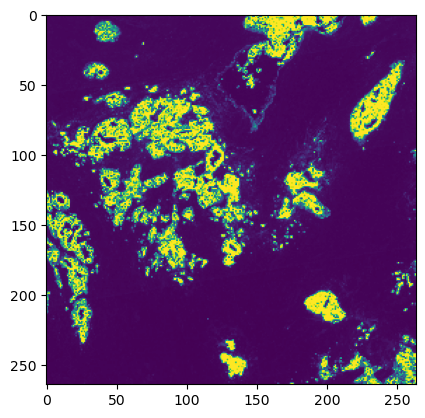

In [13]:
plt.imshow(thumbnail[channels.index('Pan-Cytokeratin'), 500:764, 500:764])

In [14]:
class MAETransform(object):
    def __init__(self, size=(256, 256), normalize=None):
        self.transforms = Compose([
            RandomCrop(size, padding_mode='reflect'),
            RandomHorizontalFlip(),
            RandomVerticalFlip(),
            normalize if normalize is not None else nn.Identity()
        ])

    def __call__(self, x):
        return self.transforms(x)
    
class InferenceTransform(object):
    def __init__(self, normalize=None):
        self.transforms = Compose([
            normalize if normalize is not None else nn.Identity()
        ])

    def __call__(self, x):
        return self.transforms(x)
    
class SlideDataset(Dataset):
    def __init__(self, slide_to_img, transform=None):
        self.slides = sorted(slide_to_img.keys())
        self.slide_to_img = slide_to_img

        self.transform = transform if transform is not None else nn.Identity()

    def __len__(self):
        return np.iinfo(np.int64).max # make infinite

    def __getitem__(self, idx):
        slide = np.random.choice(self.slides)
        idx = self.slides.index(slide)
        return {
            'slide_idx': idx,
            'img': transform(self.slide_to_img[slide])
        }

class InferenceSlideDataset(Dataset):
    def __init__(self, slide_to_img, size=(256, 256), transform=None):
        """"""
        self.size = size
        self.slides = sorted(slide_to_img.keys())
        self.slide_to_img = slide_to_img
        
        # tiles are (ph pw c h w)
        self.slide_to_tiles = {s:self.to_tiles(x) for s, x in self.slide_to_img.items()}
        self.pw, self.ph = self.slide_to_tiles[self.slides[0]].shape[:2]
        
        self.n_tiles_per_image = self.pw * self.ph
        outs = torch.stack(torch.meshgrid(
            torch.arange(len(self.slides)),
            torch.arange(self.slide_to_tiles[self.slides[0]].shape[0]),
            torch.arange(self.slide_to_tiles[self.slides[0]].shape[1])
        ))
        self.idx_to_coord = rearrange(
            outs, 'b n_slides n_rows n_cols -> (n_slides n_rows n_cols) b',
            n_slides=len(self.slides), n_rows=self.ph, n_cols=self.pw, b=3)


        self.transform = transform if transform is not None else nn.Identity()
        
    def to_tiles(self, x, size=None):
        size = self.size if size is None else size
        pad_h, pad_w = size[-2] - x.shape[-2] % size[-2], size[-1] - x.shape[-1] % size[-1]
        # left, top, right and bottom
        x = TF.pad(x, [pad_w // 2, pad_h // 2, pad_w // 2 + pad_w % 2, pad_h // 2 + pad_h % 2])
        x = x.unfold(-2, size[-2], size[-2] // 2)
        x = x.unfold(-2, size[-1], size[-1] // 2)
        x = rearrange(x, 'c ph pw h w -> ph pw c h w')
        return x

    def image_from_tiles(self, x):
        pad_h, pad_w = x.shape[-2] // 4, x.shape[-1] // 4
        x = x[..., pad_h:-pad_h, pad_w:-pad_w]
        return rearrange(x, 'ph pw c h w -> c (ph h) (pw w)')
    
    def slide_from_tiles(self, x, slide_idx, size=None):
        """
        x - (n c h w)
        """
        size = self.size if size is None else size
        mask = self.idx_to_coord[:, 0]==slide_idx
        tiles = x[mask]
        ph, pw = self.idx_to_coord[mask, 1].max() + 1, self.idx_to_coord[mask, 2].max() + 1
        
        out = torch.zeros(ph, pw, x.shape[1], size[0], size[1])
        for idx, (_, r, c) in enumerate(self.idx_to_coord[mask]):
            out[r, c] = tiles[idx]
        
        return self.image_from_tiles(out)

    def __len__(self):
        return self.idx_to_coord.shape[0]

    def __getitem__(self, idx):
        slide_idx, row_idx, col_idx = self.idx_to_coord[idx]
        slide = self.slides[slide_idx]
        return {
            'slide_idx': slide_idx,
            'row_idx': row_idx,
            'col_idx': col_idx,
            'img': transform(self.slide_to_tiles[slide][row_idx, col_idx])
        }

In [15]:
means = torch.cat([x.mean(dim=(-2, -1)).unsqueeze(0) for x in slide_to_img.values()]).mean(0)
stds = torch.cat([x.std(dim=(-2, -1)).unsqueeze(0) for x in slide_to_img.values()]).mean(0)
means, stds

(tensor([ 0.0801,  1.0852,  1.9242,  0.4242,  1.5283,  6.9707,  0.4142, 10.0162,
          3.5788,  0.2126, 11.7128,  5.6175,  6.0933,  0.1766,  1.1214,  4.9701,
          2.3110,  6.1405, 19.0076,  0.4349,  4.8628, 21.0575,  0.6115]),
 tensor([ 0.8096,  6.8269,  4.6411,  2.7208, 11.1956, 24.7025,  1.5357, 13.1523,
         10.1505,  1.7475, 36.9418, 14.6443, 21.0886,  0.8051, 10.7819,  9.9388,
          5.4503, 13.5437, 52.9554,  1.8941, 21.8240, 44.8913,  1.7298]))

In [16]:
size = (256, 256)

normalize = Normalize(means, stds)
transform = MAETransform(normalize=normalize)
ds = SlideDataset(slide_to_img, transform=transform)

In [17]:
d = ds[0]
tile = d['img']
slide_idx = d['slide_idx']
slide_idx

3

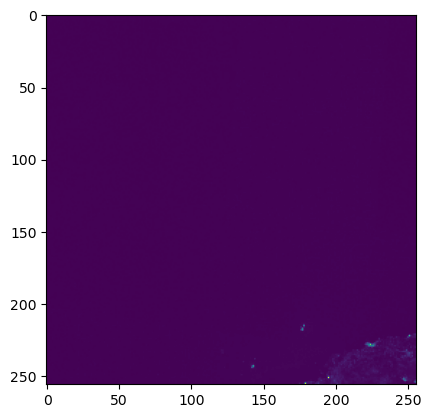

In [18]:
plt.imshow(tile[channels.index('Pan-Cytokeratin')])

In [19]:
dl = DataLoader(ds, batch_size=64, num_workers=10)

In [20]:
# from vector_quantize_pytorch import VectorQuantize

In [21]:
# vq = VectorQuantize(
#     dim = 256,
#     codebook_size = 512,     # codebook size
#     decay = 0.8,             # the exponential moving average decay, lower means the dictionary will change faster
#     commitment_weight = 1.   # the weight on the commitment loss
# )

In [22]:
# vq.codebook.shape

In [23]:
# x = torch.randn(32, 64, 256)

In [24]:
# quantized, indices, commit_loss = vq(x)

In [25]:
# quantized.shape

In [26]:
v = ViT(
    image_size = size[0],
    patch_size = 32,
    num_classes = 1000,
    dim = 1024,
    depth = 6,
    heads = 8,
    mlp_dim = 2048,
    channels=len(channels),
)

In [27]:
mae = SlideAE(
    encoder = v,
    n_slides = len(slide_to_img),
    decoder_dim = 512,      # paper showed good results with just 512
    decoder_depth = 6,       # anywhere from 1 to 8
    codebook_size = 256,
)

In [28]:
# mae = SlideMAEV2(
#     encoder = v,
#     n_slides = len(slide_to_img),
#     decoder_dim = 512,      # paper showed good results with just 512
#     decoder_depth = 6       # anywhere from 1 to 8
# )

In [29]:
b = next(iter(dl))

In [30]:
recon_loss, pred_pixel_values = mae(b['img'], b['slide_idx'])
recon_loss

tensor(1.8881, grad_fn=<MseLossBackward0>)

In [31]:
pred_pixel_values.shape

torch.Size([64, 64, 23552])

In [32]:
from einops import rearrange

In [33]:
pred_patches = rearrange(
    pred_pixel_values, 'b (h w) (p1 p2 c) -> b c (h p1) (w p2)',
    h=size[0] // 32, w=size[0] // 32, p1=32, p2=32, c=len(channels))
pred_patches.shape

torch.Size([64, 23, 256, 256])

In [34]:
# mae = SlideMAE(
#     encoder = v,
#     n_slides = len(slide_to_img),
#     masking_ratio = 0.25,   # the paper recommended 75% masked patches
#     decoder_dim = 512,      # paper showed good results with just 512
#     decoder_depth = 6       # anywhere from 1 to 8
# )

In [35]:
v = v.cuda()
mae = mae.cuda()

In [36]:
iters = 50000
lr = 1e-4
opt = torch.optim.Adam(mae.parameters(), lr=lr)

In [37]:
out_dir = '../data/mae_v12'

In [38]:
from pathlib import Path
import os
Path(out_dir).mkdir(parents=True, exist_ok=True)

In [39]:
# channel_idx = channels.index('Pan-Cytokeratin')
channel_idx = channels.index('CD45')
channel_idx

2

0 tensor(1.9592, device='cuda:0', grad_fn=<MseLossBackward0>)


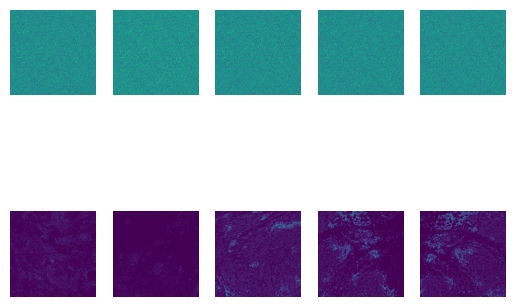

10 tensor(1.5964, device='cuda:0', grad_fn=<MseLossBackward0>)


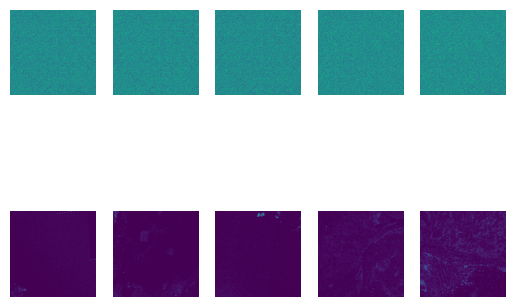

20 tensor(1.4157, device='cuda:0', grad_fn=<MseLossBackward0>)


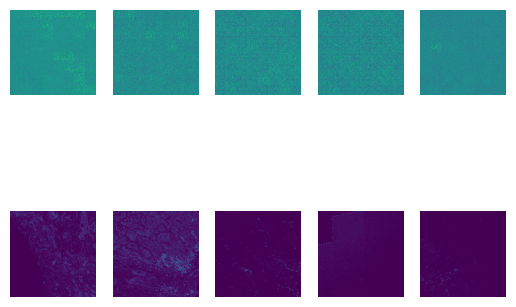

30 tensor(1.4155, device='cuda:0', grad_fn=<MseLossBackward0>)


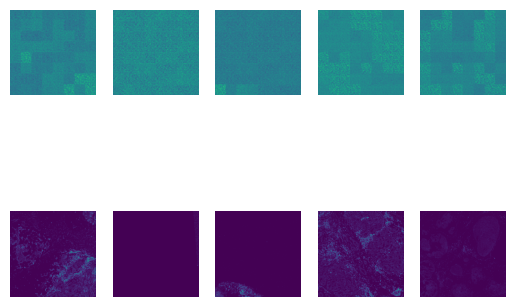

40 tensor(1.2480, device='cuda:0', grad_fn=<MseLossBackward0>)


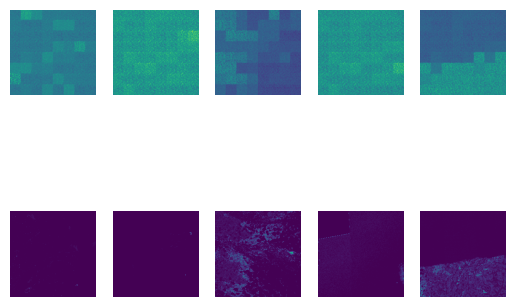

50 tensor(1.3336, device='cuda:0', grad_fn=<MseLossBackward0>)


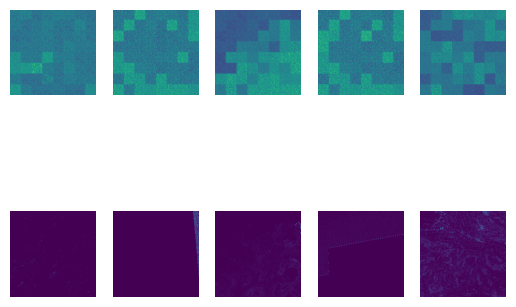

60 tensor(1.2545, device='cuda:0', grad_fn=<MseLossBackward0>)


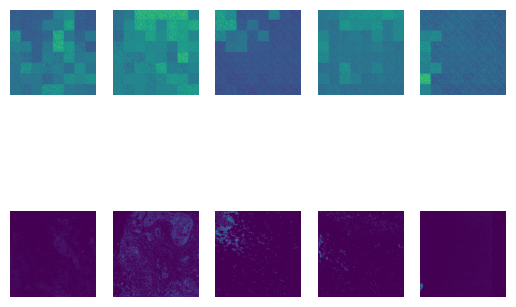

70 tensor(1.4835, device='cuda:0', grad_fn=<MseLossBackward0>)


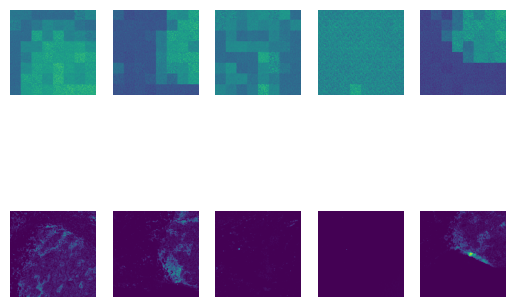

80 tensor(1.3530, device='cuda:0', grad_fn=<MseLossBackward0>)


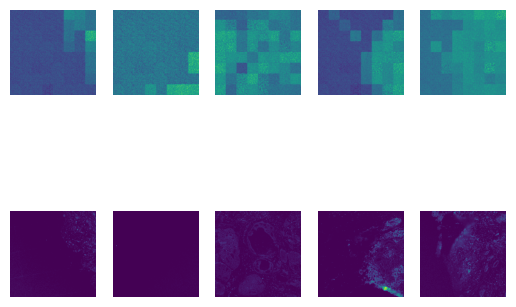

90 tensor(1.2559, device='cuda:0', grad_fn=<MseLossBackward0>)


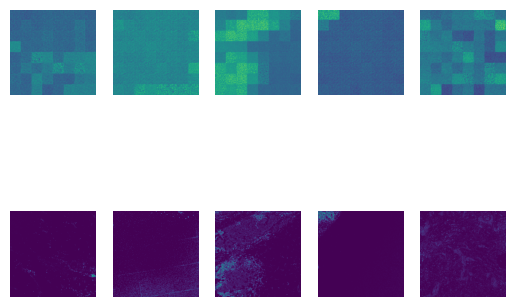

100 tensor(1.2260, device='cuda:0', grad_fn=<MseLossBackward0>)


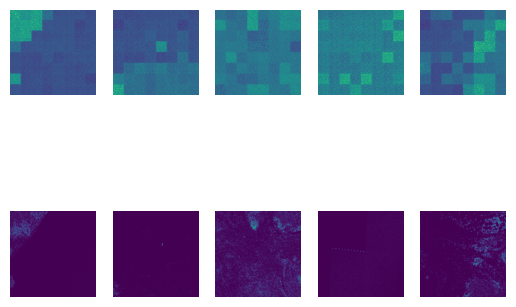

110 tensor(1.2872, device='cuda:0', grad_fn=<MseLossBackward0>)


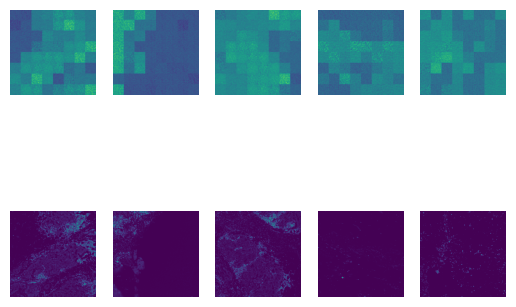

120 tensor(1.2495, device='cuda:0', grad_fn=<MseLossBackward0>)


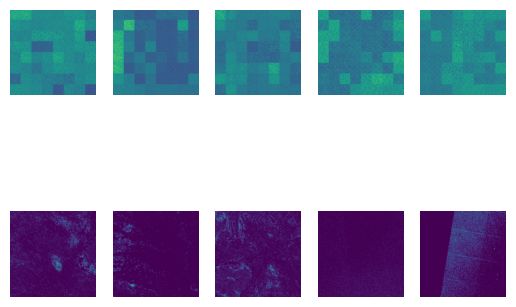

130 tensor(1.0133, device='cuda:0', grad_fn=<MseLossBackward0>)


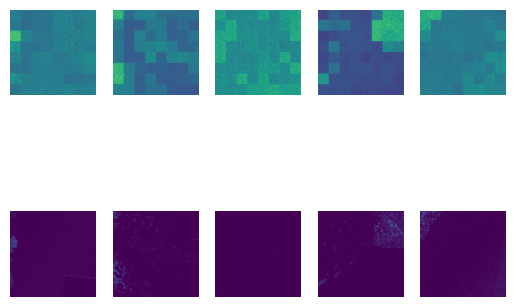

140 tensor(1.4711, device='cuda:0', grad_fn=<MseLossBackward0>)


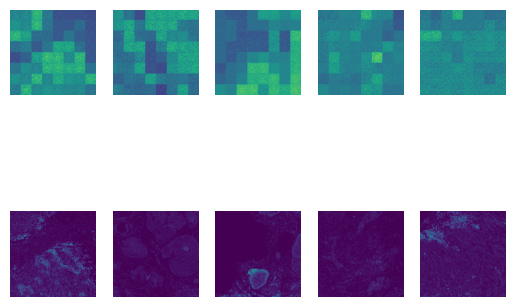

150 tensor(1.1457, device='cuda:0', grad_fn=<MseLossBackward0>)


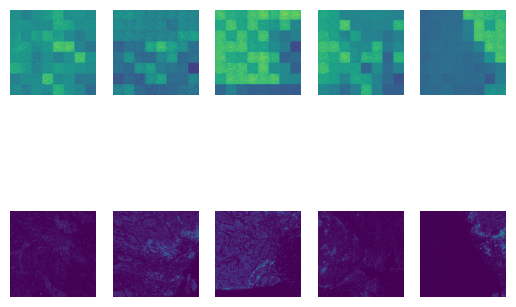

160 tensor(1.2172, device='cuda:0', grad_fn=<MseLossBackward0>)


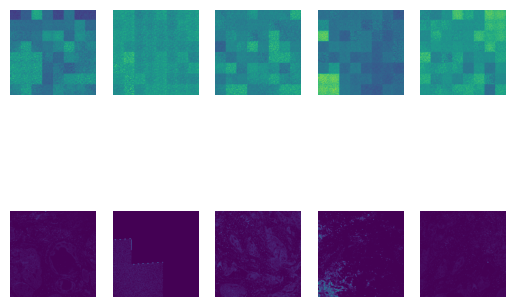

170 tensor(1.3596, device='cuda:0', grad_fn=<MseLossBackward0>)


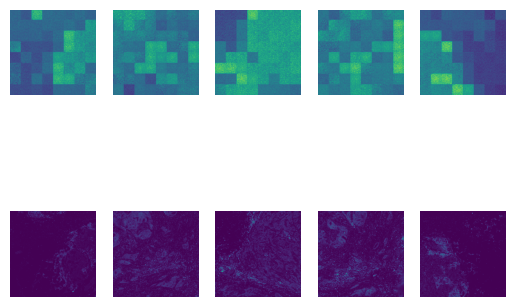

180 tensor(1.2349, device='cuda:0', grad_fn=<MseLossBackward0>)


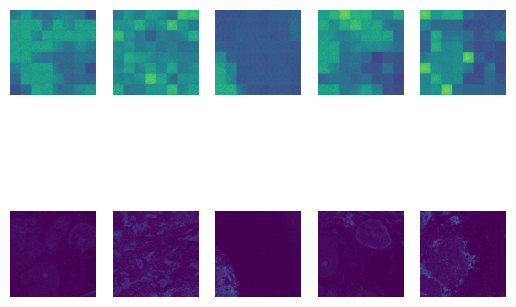

190 tensor(1.1752, device='cuda:0', grad_fn=<MseLossBackward0>)


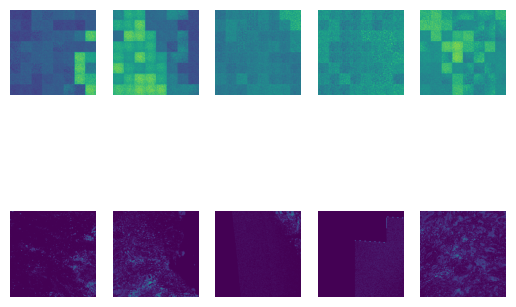

200 tensor(1.2441, device='cuda:0', grad_fn=<MseLossBackward0>)


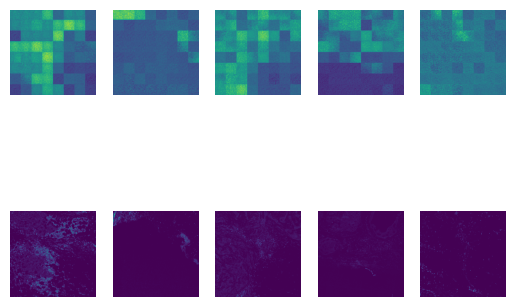

210 tensor(1.2401, device='cuda:0', grad_fn=<MseLossBackward0>)


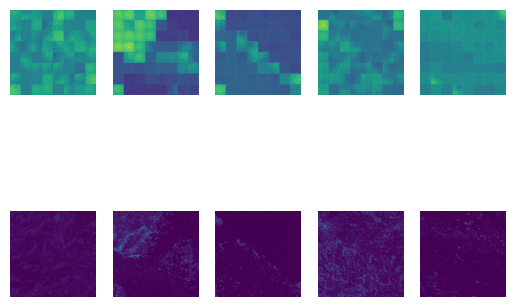

220 tensor(1.0878, device='cuda:0', grad_fn=<MseLossBackward0>)


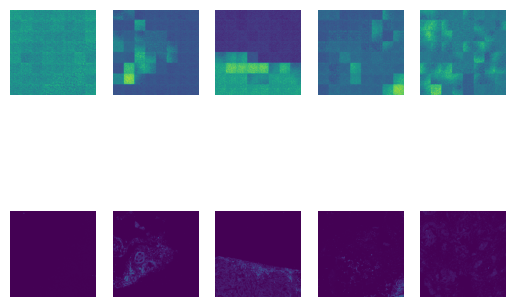

230 tensor(1.2592, device='cuda:0', grad_fn=<MseLossBackward0>)


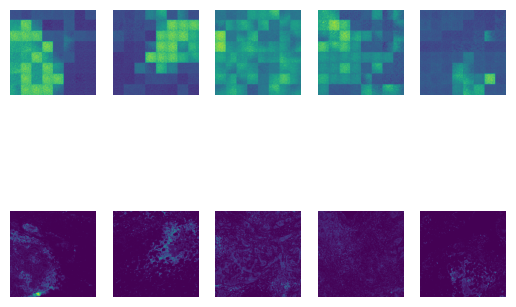

240 tensor(0.9375, device='cuda:0', grad_fn=<MseLossBackward0>)


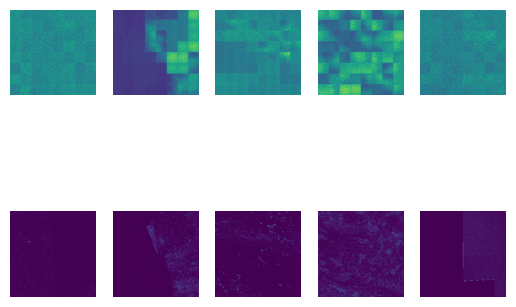

250 tensor(1.1193, device='cuda:0', grad_fn=<MseLossBackward0>)


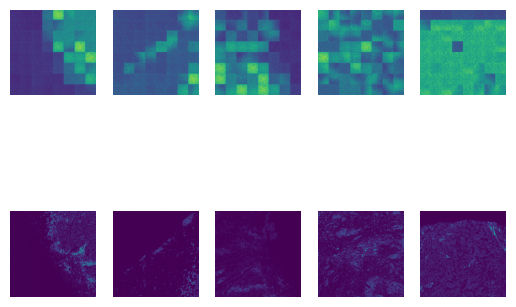

260 tensor(1.1676, device='cuda:0', grad_fn=<MseLossBackward0>)


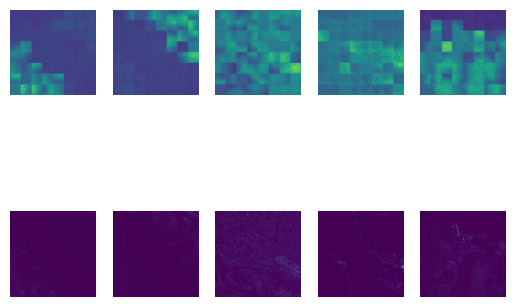

270 tensor(1.2205, device='cuda:0', grad_fn=<MseLossBackward0>)


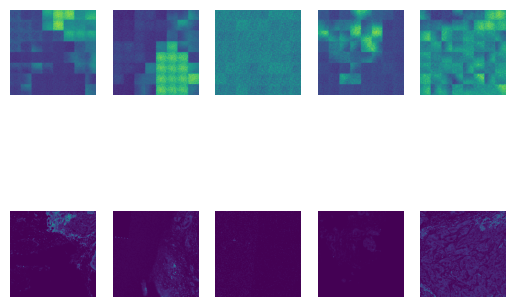

280 tensor(1.0719, device='cuda:0', grad_fn=<MseLossBackward0>)


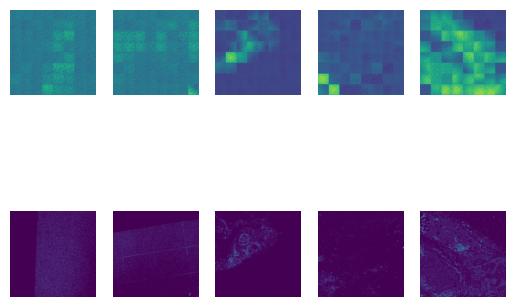

290 tensor(1.0542, device='cuda:0', grad_fn=<MseLossBackward0>)


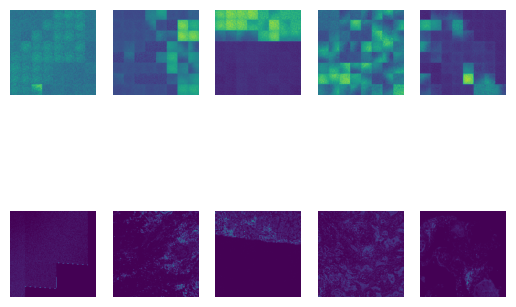

300 tensor(1.1810, device='cuda:0', grad_fn=<MseLossBackward0>)


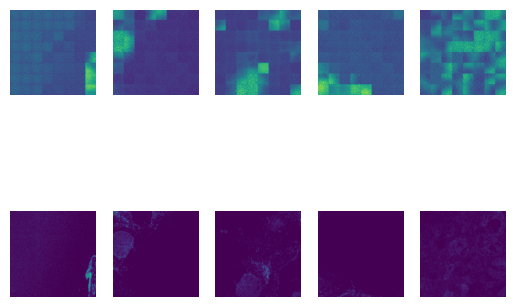

KeyboardInterrupt: 

In [40]:
for i, b in enumerate(dl):
    opt.zero_grad()
    
    slide_idxs, imgs = b['slide_idx'], b['img']
    slide_idxs, imgs = slide_idxs.cuda(), imgs.cuda()
    loss, pred_pixel_values = mae(imgs, slide_idxs)
    loss.backward()
    opt.step()
    
    if i % 10 == 0:
        print(i, loss)
        
        pred_patches = rearrange(
            pred_pixel_values, 'b (h w) (p1 p2 c) -> b c (h p1) (w p2)',
            h=size[0] // 32, w=size[0] // 32, p1=32, p2=32, c=len(channels))
        
        fig, axs = plt.subplots(nrows=2, ncols=5)
        for c in range(axs.shape[1]):
            ax1, ax2 = axs[:, c]
            ax1.imshow(pred_patches[c, channel_idx].cpu().detach())
            ax1.axis('off')
            ax2.imshow(imgs[c, channel_idx].cpu().detach())
            ax2.axis('off')
            if c==0:
                ax1.set_ylabel('pred')
                ax2.set_ylabel('true')
        plt.show()
            
        
    if i % 50 == 0:
        torch.save(mae.state_dict(), os.path.join(out_dir, f'{i}iter.pt'))
        
    if i == iters:
        break

In [61]:
# torch.save(v.state_dict(), f'../data/mae_v3/1500iter.pt')

In [41]:
size = (256, 256)

normalize = Normalize(means, stds)
transform = InferenceTransform(normalize=normalize)
inference_ds = InferenceSlideDataset(slide_to_img, transform=transform)

/data/estorrs/miniconda3/envs/mushroom/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1670525541990/work/aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [42]:
inference_dl = DataLoader(inference_ds, batch_size=32, shuffle=False)

In [43]:
x = inference_ds.image_from_tiles(inference_ds.slide_to_tiles[inference_ds.slides[0]])
x.shape

torch.Size([23, 1664, 1664])

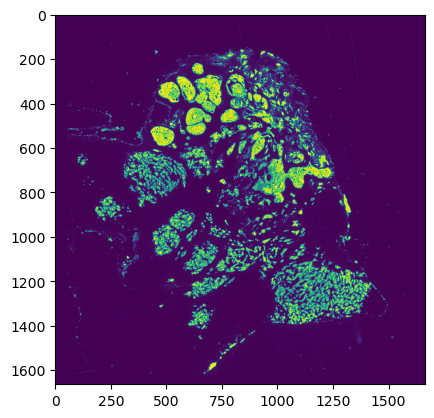

In [44]:
plt.imshow(x[channels.index('Pan-Cytokeratin')])

In [45]:
v = ViT(
    image_size = size[0],
    patch_size = 32,
    num_classes = 1000,
    dim = 1024,
    depth = 6,
    heads = 8,
    mlp_dim = 2048,
    channels=len(channels),
)

In [46]:
mae = SlideAE(
    encoder = v,
    n_slides = len(slide_to_img),
    decoder_dim = 512,      # paper showed good results with just 512
    decoder_depth = 6,       # anywhere from 1 to 8
    codebook_size = 256,
)

In [76]:
# mae.load_state_dict(torch.load('../data/mae_v12/1000iter.pt'))
# mae.load_state_dict(torch.load('../data/mae_v12/5800iter.pt'))
mae.load_state_dict(torch.load('../data/mae_v12/300iter.pt'))

<All keys matched successfully>

In [77]:
mae.eval()

SlideAE(
  (encoder): ViT(
    (to_patch_embedding): Sequential(
      (0): Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=32, p2=32)
      (1): LayerNorm((23552,), eps=1e-05, elementwise_affine=True)
      (2): Linear(in_features=23552, out_features=1024, bias=True)
      (3): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
    )
    (dropout): Dropout(p=0.0, inplace=False)
    (transformer): Transformer(
      (layers): ModuleList(
        (0): ModuleList(
          (0): PreNorm(
            (norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
            (fn): Attention(
              (attend): Softmax(dim=-1)
              (dropout): Dropout(p=0.0, inplace=False)
              (to_qkv): Linear(in_features=1024, out_features=1536, bias=False)
              (to_out): Sequential(
                (0): Linear(in_features=512, out_features=1024, bias=True)
                (1): Dropout(p=0.0, inplace=False)
              )
            )
          )
          (1): 

In [78]:
all_encoded_tokens_prequantize = torch.zeros(
    len(inference_ds), size[0] // 32, size[1] // 32, v.pos_embedding.shape[-1])
all_encoded_tokens = torch.zeros(len(inference_ds), size[0] // 32, size[1] // 32, v.pos_embedding.shape[-1])
all_decoded_tokens = torch.zeros(len(inference_ds), size[0] // 32, size[1] // 32, mae.decoder_dim)
all_pred_patches = torch.zeros(len(inference_ds), len(channels), size[0], size[1])
all_indices = torch.zeros(len(inference_ds), size[0] // 32, size[1] // 32, dtype=torch.long)
bs = inference_dl.batch_size
with torch.no_grad():
    for i, b in enumerate(inference_dl):
        x, slide_idx = b['img'], b['slide_idx']
        if v.pos_embedding.is_cuda:
            x, slide_idx = x.to(v.pos_embedding.device), slide_idx.to(v.pos_embedding.device)
        
        encoded_tokens_prequantize = mae.encode(x, slide_idx)
        encoded_tokens, indices, _ = mae.quantize(encoded_tokens_prequantize)
        decoded_tokens = mae.decode(encoded_tokens)
        pred_pixel_values = mae.to_pixels(decoded_tokens[:, 1:])

        encoded_tokens_prequantize = rearrange(encoded_tokens_prequantize[:, 1:], 'b (h w) d -> b h w d',
                                  h=size[0] // 32, w=size[1] // 32)
        encoded_tokens = rearrange(encoded_tokens[:, 1:], 'b (h w) d -> b h w d',
                                  h=size[0] // 32, w=size[1] // 32)
        indices = rearrange(indices, 'b (h w) -> b h w',
                                  h=size[0] // 32, w=size[1] // 32)
        decoded_tokens = rearrange(decoded_tokens[:, 1:], 'b (h w) d -> b h w d',
                                  h=size[0] // 32, w=size[1] // 32)
        pred_patches = rearrange(
            pred_pixel_values, 'b (h w) (p1 p2 c) -> b c (h p1) (w p2)',
            h=size[0] // 32, w=size[0] // 32, p1=32, p2=32, c=len(channels))
        
        all_encoded_tokens_prequantize[i * bs:(i + 1) * bs] = encoded_tokens_prequantize.cpu().detach()
        all_encoded_tokens[i * bs:(i + 1) * bs] = encoded_tokens.cpu().detach()
        all_indices[i * bs:(i + 1) * bs] = indices.cpu().detach()
        all_decoded_tokens[i * bs:(i + 1) * bs] = decoded_tokens.cpu().detach()
        all_pred_patches[i * bs:(i + 1) * bs] = pred_patches.cpu().detach()

In [79]:
all_encoded_tokens_prequantize.shape, all_encoded_tokens.shape, all_decoded_tokens.shape, all_pred_patches.shape, all_indices.shape

(torch.Size([676, 8, 8, 1024]),
 torch.Size([676, 8, 8, 1024]),
 torch.Size([676, 8, 8, 512]),
 torch.Size([676, 23, 256, 256]),
 torch.Size([676, 8, 8]))

In [80]:
x = inference_ds.slide_from_tiles(all_pred_patches, 0)
x.shape

torch.Size([23, 1664, 1664])

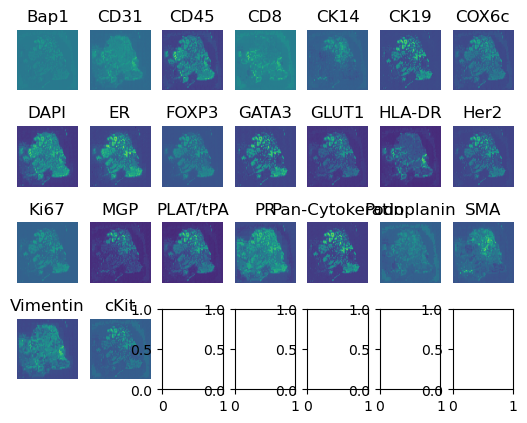

In [81]:
n_cols = 7
n_rows = len(channels) // n_cols + 1
rc = [(i, j) for i in range(n_rows) for j in range(n_cols)]

fig, axs = plt.subplots(ncols=n_cols, nrows=n_rows)
rc = [(i, j) for i in range(n_rows) for j in range(n_cols)]
for (row_idx, col_idx), c in zip(rc, channels):
    ax = axs[row_idx, col_idx]
    ax.imshow(x[channels.index(c)])
    ax.axis('off')
    ax.set_title(c)

In [82]:
ps = size[0] // 32
recon_embs = torch.stack(
    [inference_ds.slide_from_tiles(
        rearrange(all_encoded_tokens, 'n h w c -> n c h w'),
        i, size=(ps, ps))
    for i in range(len(inference_ds.slides))]
)
recon_embs = rearrange(recon_embs, 'b c h w -> b h w c')
recon_embs.shape

torch.Size([4, 52, 52, 1024])

In [83]:
recon_embs_prequant = torch.stack(
    [inference_ds.slide_from_tiles(
        rearrange(all_encoded_tokens_prequantize, 'n h w c -> n c h w'),
        i, size=(ps, ps))
    for i in range(len(inference_ds.slides))]
)
recon_embs_prequant = rearrange(recon_embs_prequant, 'b c h w -> b h w c')
recon_embs_prequant.shape

torch.Size([4, 52, 52, 1024])

In [84]:
recon_multi = torch.stack(
    [inference_ds.image_from_tiles(inference_ds.slide_to_tiles[s])
    for s in inference_ds.slides]
)
recon_multi = TF.resize(recon_multi, (52, 52))
recon_multi.shape

torch.Size([4, 23, 52, 52])

In [85]:
recon_indices = torch.stack(
    [inference_ds.slide_from_tiles(
        rearrange(all_indices, 'n h w -> n 1 h w'),
        i, size=(ps, ps))
    for i in range(len(inference_ds.slides))]
)
recon_indices = rearrange(recon_indices, 'b c h w -> b h w c').to(torch.long).squeeze()
recon_indices.shape

torch.Size([4, 52, 52])

In [86]:
def display_labeled_as_rgb(labeled, cmap=None):
    if isinstance(labeled, torch.Tensor):
        labeled = labeled.numpy()
    cmap = sns.color_palette() if cmap is None else cmap
    labels = sorted(np.unique(labeled))
    if len(cmap) < len(labels):
        raise RuntimeError('cmap is too small')
    new = np.zeros((labeled.shape[0], labeled.shape[1], 3))
    for l in labels:
        c = cmap[l]
        new[labeled==l] = c
    return new

IndexError: list index out of range

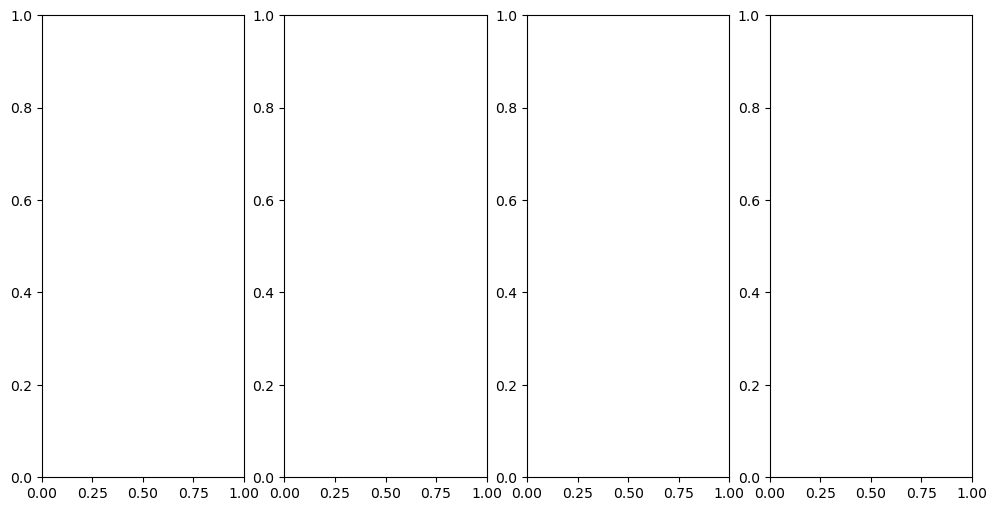

In [58]:
import seaborn as sns
cmap = sns.color_palette('tab20') + sns.color_palette('tab20b') + sns.color_palette('tab20c')
fig, axs = plt.subplots(ncols=recon_indices.shape[0], figsize=(12, 6))
for i, labeled in enumerate(recon_indices):
    axs[i].imshow(display_labeled_as_rgb(labeled, cmap=cmap))
    axs[i].axis('off')

In [74]:
recon_embs_prequant.shape

torch.Size([4, 52, 52, 1024])

In [75]:
mae.vq.codebook.shape

torch.Size([20, 1024])

In [76]:
dists = torch.cdist(
    rearrange(recon_embs_prequant, 'b h w d -> (b h w) d'),
    mae.vq.codebook
)
b, h, w, *_ = recon_embs_prequant.shape
dists = rearrange(dists, '(b h w) d -> b h w d', b=b, h=h, w=w)
dists.shape

torch.Size([4, 52, 52, 20])

In [77]:
import seaborn as sns
from scipy.ndimage import binary_fill_holes

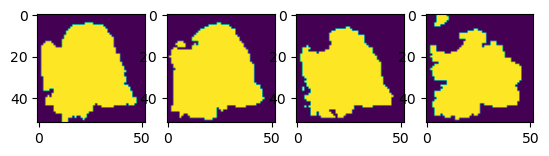

In [78]:
blurred_multi = TF.gaussian_blur(recon_multi, [3, 3])
multiplex_masks = blurred_multi[:, channels.index('DAPI')] > 4.8
multiplex_masks = torch.stack([
    torch.tensor(binary_fill_holes(mask.numpy()))
    for mask in multiplex_masks
])

fig, axs = plt.subplots(ncols=len(multiplex_masks))
for mask, ax in zip(multiplex_masks, axs):
    ax.imshow(mask)

In [79]:
# cluster_ids[~multiplex_masks] = cluster_ids.max() + 1
dists[~multiplex_masks] = dists.amax((0, 1, 2))

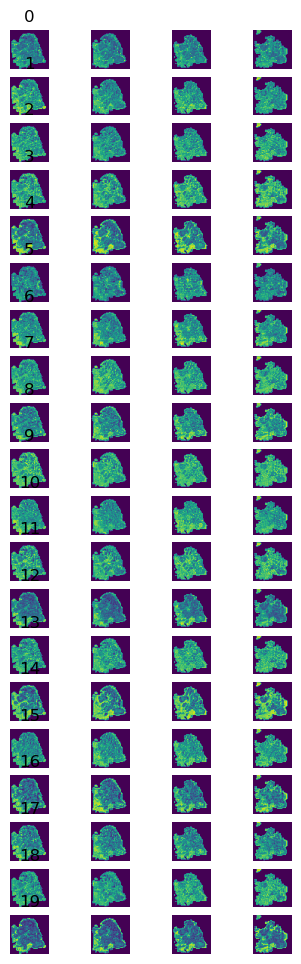

In [80]:
fig, axs = plt.subplots(ncols=dists.shape[0], nrows=dists.shape[-1], figsize=(4, 12))
for r in range(dists.shape[-1]):
    for c in range(dists.shape[0]):
        ax = axs[r, c]
        img = dists[c, ..., r]
        ax.imshow(img, cmap='viridis_r')
        ax.axis('off')
        if c == 0:
            ax.set_title(r)

In [98]:
locations = np.asarray([2, 12, 22, 31])
locations -= locations.min()
locations

array([ 0, 10, 20, 29])

In [100]:
from torchio.transforms import Resize

In [101]:
scaler = 10.

In [102]:
dist_volume = torch.zeros(locations.max(), dists.shape[3], int(dists.shape[1] * scaler), int(dists.shape[2] * scaler))
for i in range(dists.shape[0] - 1):
    l1, l2 = locations[i], locations[i+1]
    stack = rearrange(dists[i:i+2], 'b h w c -> c b h w')
    transform = Resize((l2 - l1, int(stack.shape[-2] * scaler), int(stack.shape[-1] * scaler)))
    out = transform(stack)
    dist_volume[l1:l2] = rearrange(out, 'c b h w -> b c h w')
dist_volume.shape

torch.Size([29, 20, 520, 520])

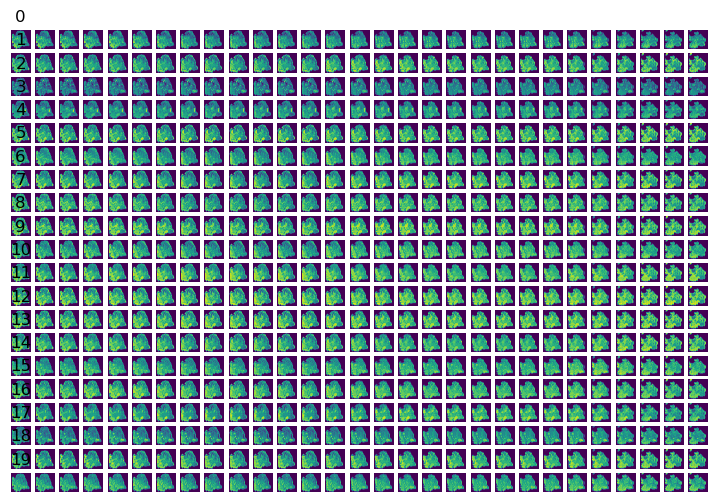

In [105]:
fig, axs = plt.subplots(ncols=dist_volume.shape[0], nrows=dist_volume.shape[1], figsize=(9, 6))
for r in range(dist_volume.shape[1]):
    for c in range(dist_volume.shape[0]):
        ax = axs[r, c]
        img = dist_volume[c, r]
        ax.imshow(img, cmap='viridis_r')
        ax.axis('off')
        if c == 0:
            ax.set_title(r)

In [106]:
to_save = dist_volume.max() - dist_volume
to_save /= to_save.max()
to_save *= 255.
to_save = to_save.to(torch.uint8).numpy()
to_save.shape

(29, 20, 520, 520)

In [107]:
result_dir = os.path.join(out_dir, 'results')
Path(result_dir).mkdir(parents=True, exist_ok=True)

In [108]:
for cluster in range(to_save.shape[1]):
    tifffile.imsave(os.path.join(result_dir, f'cluster_{cluster}.tif'), to_save[:, cluster, :, :])

In [109]:
d = {
    'recon_embs': recon_embs,
    'recon_imgs': recon_multi,
    'recon_embs_prequant': recon_embs_prequant,
    'recon_cluster_ids': recon_indices,
    'recon_cluster_dists': dists,
    'dists_volume': dist_volume
}
torch.save(d, os.path.join(result_dir, 'results_1000iter.pt'))

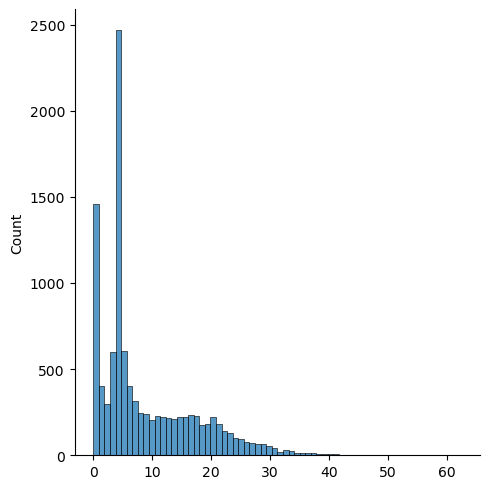

In [87]:
import seaborn as sns
blurred_multi = TF.gaussian_blur(recon_multi, [3, 3])
sns.displot(blurred_multi[:, channels.index('DAPI')].flatten().numpy())

In [88]:
from scipy.ndimage import binary_fill_holes

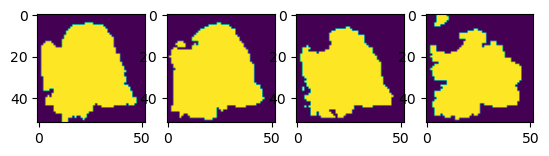

In [89]:
multiplex_masks = blurred_multi[:, channels.index('DAPI')] > 4.8
multiplex_masks = torch.stack([
    torch.tensor(binary_fill_holes(mask.numpy()))
    for mask in multiplex_masks
])

fig, axs = plt.subplots(ncols=len(multiplex_masks))
for mask, ax in zip(multiplex_masks, axs):
    ax.imshow(mask)

In [90]:
multiplex_masks.shape

torch.Size([4, 52, 52])

In [91]:
target = recon_embs.numpy()
target.shape

(4, 52, 52, 1024)

In [92]:
rc = torch.zeros(all_encoded_tokens.shape[:-1], dtype=torch.long)
print(rc.shape)
idx_to_var = [(r, c) for r in range(rc.shape[1]) for c in range(rc.shape[2])]
var_to_idx = {v:i for i, v in enumerate(idx_to_var)}
for i, (slide_idx, row_idx, col_idx) in enumerate(inference_ds.idx_to_coord):
    for r in range(rc.shape[1]):
        for c in range(rc.shape[2]):
            rc[i, r, c] = var_to_idx[(r, c)]
hots = torch.nn.functional.one_hot(rc)

X_coords = torch.stack(
    [inference_ds.slide_from_tiles(
        rearrange(hots, 'n h w c -> n c h w'),
        i, size=(ps, ps))
    for i in range(len(inference_ds.slides))]
)
X_coords = rearrange(X_coords, 'b c h w -> b h w c')
X_coords.shape

torch.Size([676, 8, 8])


torch.Size([4, 52, 52, 64])

In [93]:
from einops import repeat
X_slides = repeat(torch.arange(multiplex_masks.shape[0]), 'b -> b h w', h=52, w=52)
X_slides = torch.nn.functional.one_hot(X_slides)
X_slides.shape


torch.Size([4, 52, 52, 4])

In [94]:
X = torch.cat((X_coords, X_slides), dim=-1)
X = X.numpy()
X.shape

(4, 52, 52, 68)

In [95]:
target = rearrange(target, 'b h w c -> (b h w) c')
X = rearrange(X, 'b h w c -> (b h w) c')
target.shape, X.shape

((10816, 1024), (10816, 68))

In [96]:
from sklearn.linear_model import LinearRegression
lm = LinearRegression()
lm.fit(X, target)
residuals = lm.predict(X) - target
embs_regressed = rearrange(residuals, '(b h w) c -> b h w c',
                           b=X_coords.shape[0], h=X_coords.shape[1], w=X_coords.shape[2])
embs_regressed.shape

(4, 52, 52, 1024)

In [97]:
from sklearn.cluster import KMeans

In [98]:
n_clusters = 20
clusterer = KMeans(n_clusters=n_clusters)

In [99]:
tokens = torch.tensor(embs_regressed)
tokens.shape

torch.Size([4, 52, 52, 1024])

In [100]:
# x = rearrange(tokens, 'b h w d -> (b h w) d').numpy()
x = tokens[multiplex_masks].numpy()
clusterer.fit(x)
dists = clusterer.transform(rearrange(tokens, 'b h w d -> (b h w) d').numpy())
cluster_ids = torch.tensor(dists.argmin(1))
cluster_ids.shape

torch.Size([10816])

In [101]:
cluster_ids = rearrange(cluster_ids, '(b h w) -> b h w',
                        b=tokens.shape[0], h=tokens.shape[1], w=tokens.shape[2])
dists = rearrange(torch.tensor(dists), '(b h w) d -> b h w d',
                 b=tokens.shape[0], h=tokens.shape[1], w=tokens.shape[2])
cluster_ids.shape

torch.Size([4, 52, 52])

In [102]:
cluster_ids[~multiplex_masks] = cluster_ids.max() + 1
dists[~multiplex_masks] = dists.amax((0, 1, 2))

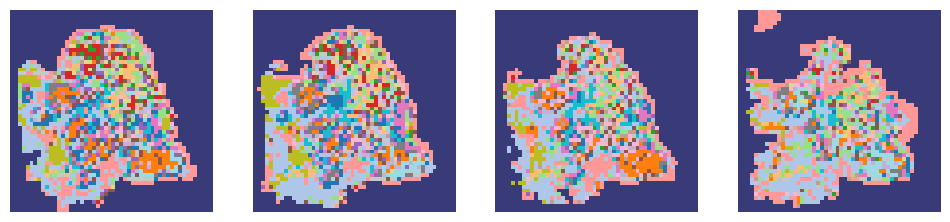

In [103]:
cmap = sns.color_palette('tab20') + sns.color_palette('tab20b') + sns.color_palette('tab20c')
fig, axs = plt.subplots(ncols=cluster_ids.shape[0], figsize=(12, 6))
for i, labeled in enumerate(cluster_ids):
    axs[i].imshow(display_labeled_as_rgb(labeled, cmap=cmap))
    axs[i].axis('off')

In [132]:
labeled = cluster_ids[0]
labeled.shape

torch.Size([52, 52])

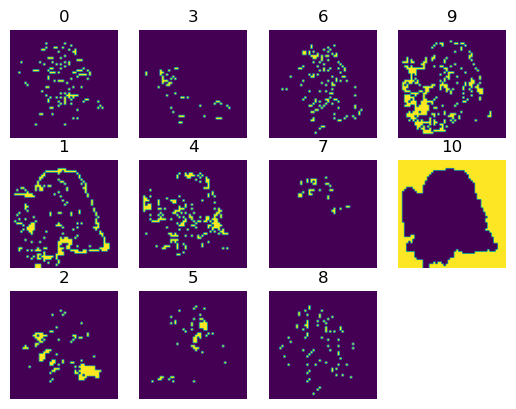

In [133]:

ncols = 4
nrows = (n_clusters + 1) // ncols + 1
    
coords = np.stack(np.meshgrid(np.arange(nrows), np.arange(ncols)))
coords = rearrange(coords, 'd h w -> (h w) d')

fig, axs = plt.subplots(nrows=nrows, ncols=ncols)
for i, (r, c) in zip(range(n_clusters + 1), coords):
    m = labeled==i
    axs[r, c].imshow(m)
    axs[r, c].set_title(i)

for ax in axs.flatten():
    ax.axis('off')
    

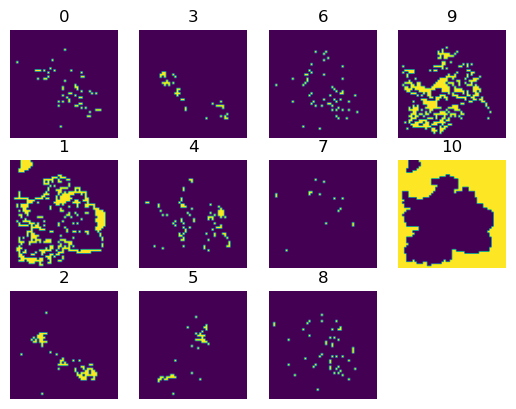

In [134]:
labeled = cluster_ids[-1]

fig, axs = plt.subplots(nrows=nrows, ncols=ncols)
for i, (r, c) in zip(range(n_clusters + 1), coords):
    m = labeled==i
    axs[r, c].imshow(m)
    axs[r, c].set_title(i)

for ax in axs.flatten():
    ax.axis('off')

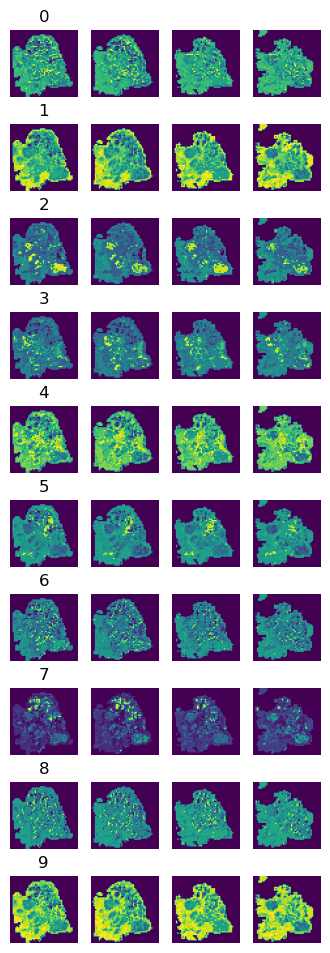

In [139]:
fig, axs = plt.subplots(ncols=dists.shape[0], nrows=n_clusters, figsize=(4, 12))
for r in range(n_clusters):
    for c in range(dists.shape[0]):
        ax = axs[r, c]
        img = dists[c, ..., r]
        ax.imshow(img, cmap='viridis_r')
        ax.axis('off')
        if c == 0:
            ax.set_title(r)

In [140]:
locations = np.asarray([2, 12, 22, 31])
locations -= locations.min()
locations

array([ 0, 10, 20, 29])

In [141]:
from torchio.transforms import Resize

In [142]:
scaler = 10.

In [143]:
dist_volume = torch.zeros(locations.max(), dists.shape[3], int(dists.shape[1] * scaler), int(dists.shape[2] * scaler))
for i in range(dists.shape[0] - 1):
    l1, l2 = locations[i], locations[i+1]
    stack = rearrange(dists[i:i+2], 'b h w c -> c b h w')
    transform = Resize((l2 - l1, int(stack.shape[-2] * scaler), int(stack.shape[-1] * scaler)))
    out = transform(stack)
    dist_volume[l1:l2] = rearrange(out, 'c b h w -> b c h w')
dist_volume.shape

torch.Size([29, 10, 520, 520])

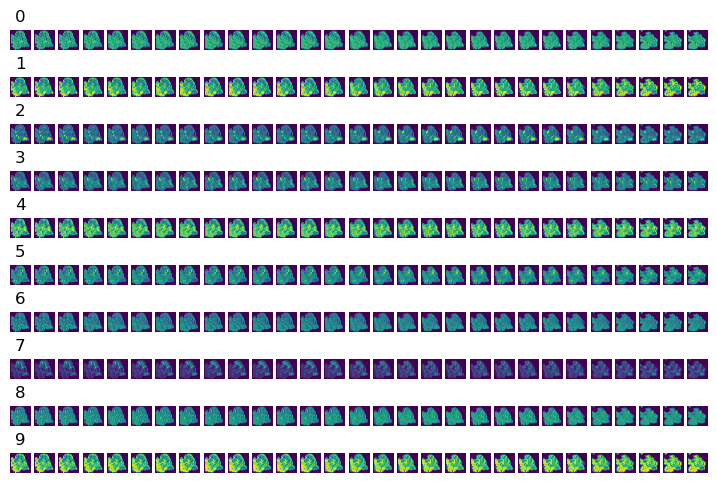

In [146]:
fig, axs = plt.subplots(ncols=dist_volume.shape[0], nrows=n_clusters, figsize=(9, 6))
for r in range(n_clusters):
    for c in range(dist_volume.shape[0]):
        ax = axs[r, c]
        img = dist_volume[c, r]
        ax.imshow(img, cmap='viridis_r')
        ax.axis('off')
        if c == 0:
            ax.set_title(r)

In [147]:
to_save = dist_volume.max() - dist_volume
to_save /= to_save.max()
to_save *= 255.
to_save = to_save.to(torch.uint8).numpy()
to_save.shape

(29, 10, 520, 520)

In [148]:
result_dir = '/data/estorrs/mushroom/data/mae_v11/results'
Path(result_dir).mkdir(parents=True, exist_ok=True)

In [149]:
for cluster in range(to_save.shape[1]):
    tifffile.imsave(os.path.join(result_dir, f'cluster_{cluster}.tif'), to_save[:, cluster, :, :])

In [153]:
d = {
    'recon_embs': recon_embs,
    'recon_imgs': recon_multi,
    'recon_embs_regressed': torch.tensor(embs_regressed),
    'recon_cluster_ids': cluster_ids,
    'recon_cluster_dists': dists,
    'distance_volume': dist_volume
}
torch.save(d, os.path.join(result_dir, 'results_500iter.pt'))

In [156]:
import pandas as pd
data = []
x = rearrange(recon_multi, 'b c h w -> b h w c')
for cluster in range(dists.shape[-1]):
    data.append(x[cluster_ids==cluster].mean(0).numpy())
data = np.vstack(data)
df = pd.DataFrame(data=data, columns=channels)
df

Bap1      CD31       CD45       CD8       CK14       CK19     COX6c  \
0  0.123188  2.005072   3.759420  0.287681   3.113044  19.468117  0.810870   
1  0.032258  0.496437   0.714929  0.217929   0.909602   2.901538  0.201988   
2  0.199689  1.757261   5.853734  0.241701   0.342324  42.453320  1.247407   
3  0.188503  4.167112  14.211230  3.902406   0.431818  13.925134  1.589572   
4  0.095378  3.647479   5.156723  1.376471   0.757563   3.293698  0.779832   
5  0.087558  3.316820   2.101382  0.057604  11.500000   5.793779  0.882488   
6  0.132768  1.680085   3.972458  0.307203   3.969633  27.784605  0.927966   
7  0.292593  1.992593   5.994444  0.055556   3.114815  60.018520  1.568519   
8  0.174812  2.967105   4.341166  0.359023   4.446429  26.873119  1.107143   
9  0.045413  1.812462   1.485818  0.244116   0.824683   2.202173  0.367984   

        DAPI         ER     FOXP3  ...      Her2      Ki67        MGP  \
0  18.334784   9.727536  0.451449  ...  0.410870  3.934783   8.283334   
1   7.433046   0.915604  0.099587  ...  0.048575  0.596587   3.126407   
2  22.868258  15.254668  0.794606  ...  0.825726  5.846473   8.415976   
3  33.538769  17.308823  0.843583  ...  0.403743  3.351604   6.241979   
4  20.730251   7.231092  0.347899  ...  0.196639  1.005462   7.338655   
5  13.737328   4.423963  0.218894  ...  0.260369  1.625576  12.731566   
6  19.071327  11.725988  0.568503  ...  0.593220  2.397599  10.028249   
7  28.498148  24.105556  1.137037  ...  1.544444  5.370370  38.185184   
8  20.529135  11.308270  0.574248  ...  0.576128  3.262218  10.093045   
9  10.860139   1.794206  0.106669  ...  0.109988  0.795413   5.518407   

    PLAT/tPA         PR  Pan-Cytokeratin  Podoplanin        SMA   Vimentin  \
0   5.539855  12.534782        52.552174    0.521739  11.536957  43.452900   
1   1.027194   3.705176         8.453676    0.190923   2.424606  13.963991   
2   7.356328  17.749481       105.094917    0.214212   4.412344  23.058092   
3   6.188503   9.874331        28.331551    1.303476   6.652406  75.248665   
4   4.412185   9.383614        10.677311    0.738235   8.631513  69.395798   
5   5.262673   7.945853        24.722351    0.852535  42.029953  52.307602   
6   6.352401  13.942090        69.139122    0.504237  12.630650  36.395481   
7  14.611111  19.898148       177.985184    0.807407   7.188889  20.842592   
8   5.676692  15.481203        66.766914    0.533835  14.734962  38.679512   
9   2.160079  11.460923         7.451720    0.262523   6.625679  35.052956   

       cKit  
0  0.909420  
1  0.409602  
2  1.187759  
3  0.850267  
4  0.639496  
5  0.555300  
6  1.129943  
7  2.727778  
8  1.085526  
9  0.379149  

[10 rows x 23 columns]

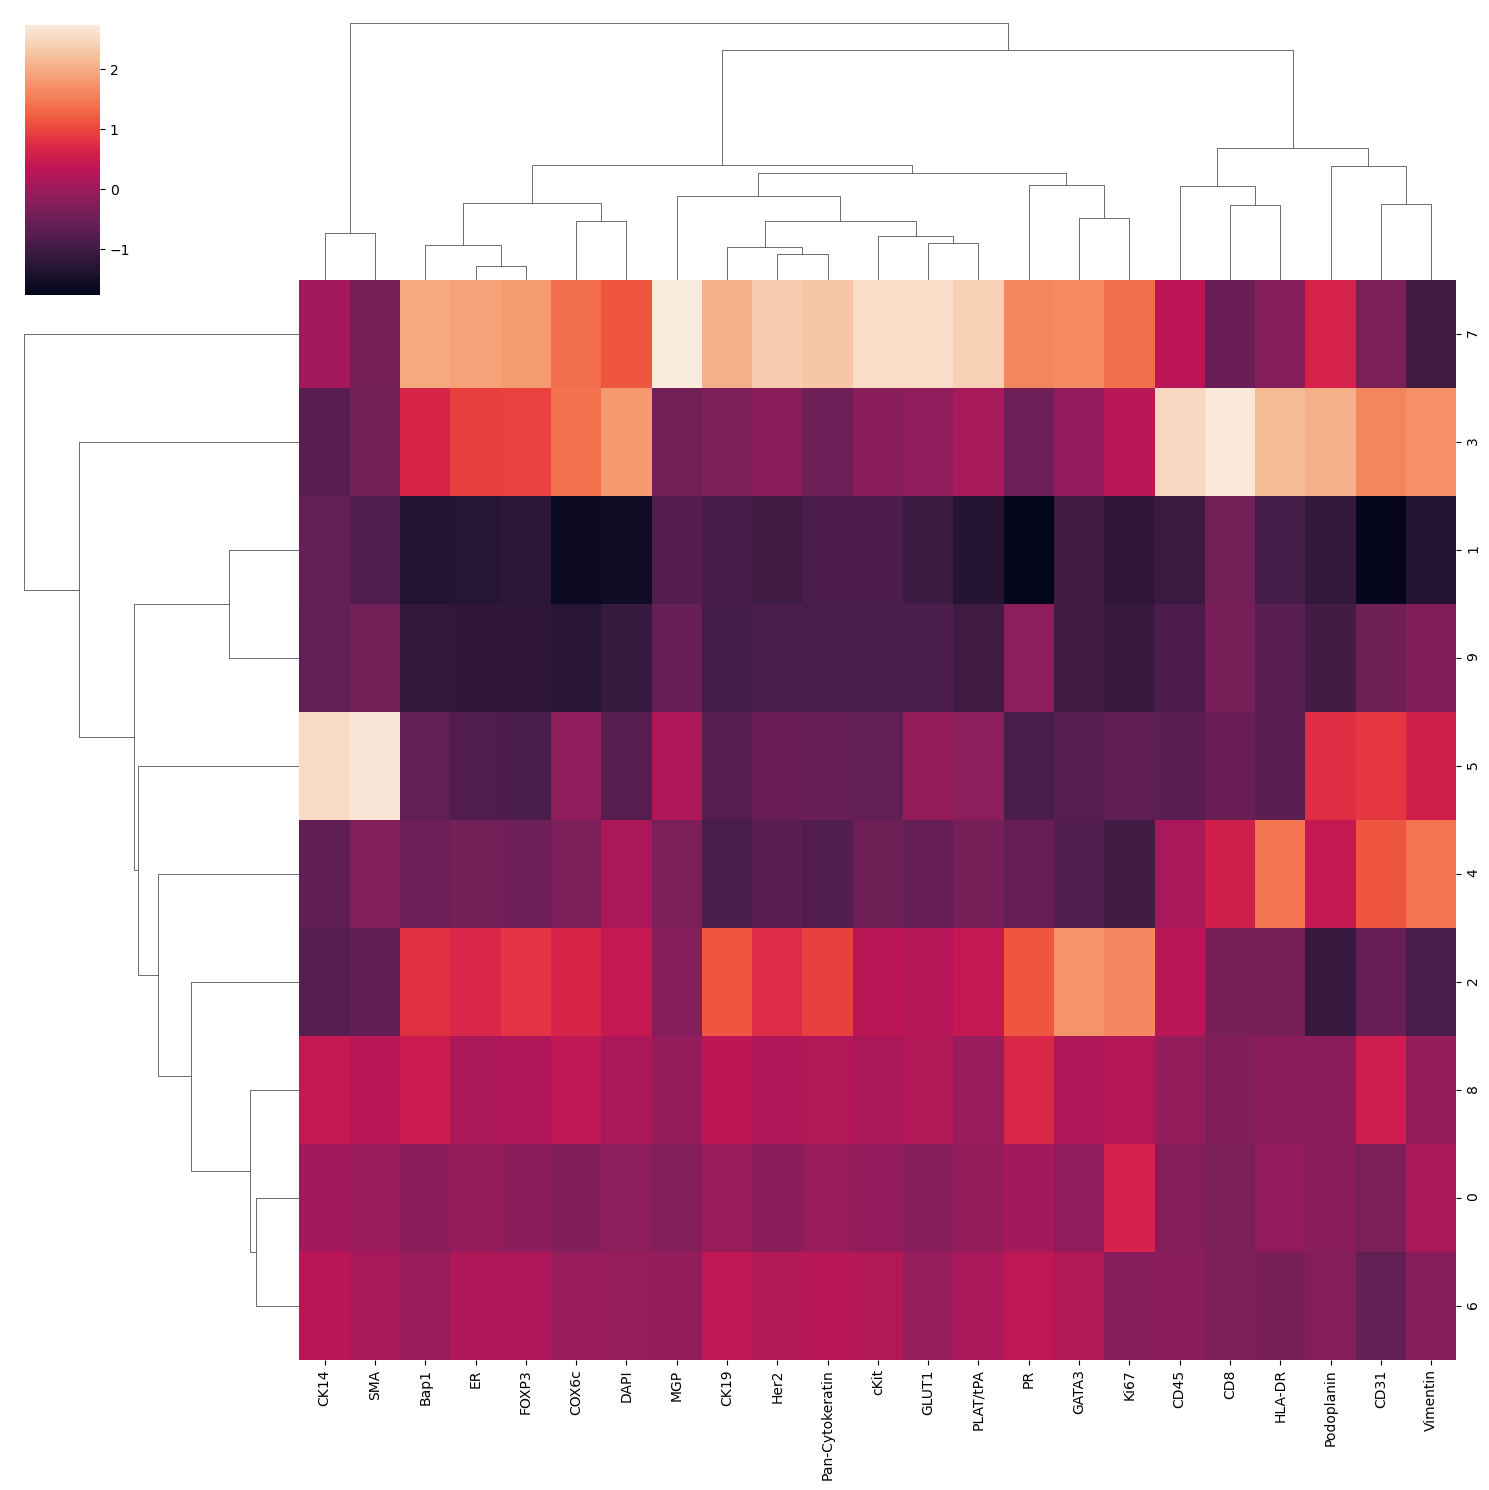

In [158]:
sns.clustermap(df, figsize=(15, 15), z_score=True)